# Performance

This notebook reproduces the charts on performance of the datalab, assesing different types of data access from different locations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
home = pd.read_csv("home.csv")
hub = pd.read_csv("hub.csv")
ifca = pd.read_csv("ifca.csv")

home["location"] = "Home"
hub["location"] = "Hub"
ifca["location"] = "IFCA"

home["bytes_recv"] = home["bytes_recv"] / 2**20
home.loc[home["name"]=="local", "name"] = "netCDF"
home.loc[home["name"]=="opendap-hub-compressed", "name"] = "OPeNDAP\n(deflate=True)"
home.loc[home["name"]=="opendap-hub-uncompressed", "name"] = "OPeNDAP\n(deflate=False)"

hub["bytes_recv"] = hub["bytes_recv"] / 2**20
hub.loc[hub["name"]=="local", "name"] = "netCDF"
hub.loc[hub["name"]=="opendap-hub-compressed", "name"] = "OPeNDAP\n(deflate=True)"
hub.loc[hub["name"]=="opendap-hub-uncompressed", "name"] = "OPeNDAP\n(deflate=False)"

ifca["bytes_recv"] = ifca["bytes_recv"] / 2**20
ifca.loc[ifca["name"]=="local", "name"] = "netCDF"
ifca.loc[ifca["name"]=="opendap-hub-compressed", "name"] = "OPeNDAP\n(deflate=True)"
ifca.loc[ifca["name"]=="opendap-hub-uncompressed", "name"] = "OPeNDAP\n(deflate=False)"

# add throughput
home["throughput"] = home["bytes_recv"] / home["time"]
hub["throughput"] = hub["bytes_recv"] / hub["time"]
ifca["throughput"] = ifca["bytes_recv"] / ifca["time"]

hub.loc[hub["name"]=="netCDF","throughput"] = (3594518528 / 2**20) / hub[hub["name"]=="netCDF"]["time"]

In [3]:
home_mean = home[["name", "workers", "location", "time", "bytes_recv", "throughput"]].groupby(["location", "name", "workers"]).agg(["mean", "std", "max", "min"])
hub_mean = hub[["name", "workers", "location", "time", "bytes_recv", "throughput"]].groupby(["location", "name", "workers"]).agg(["mean", "std", "max", "min"])
ifca_mean = ifca[["name", "workers", "location", "time", "bytes_recv", "throughput"]].groupby(["location", "name", "workers"]).agg(["mean", "std", "max", "min"])

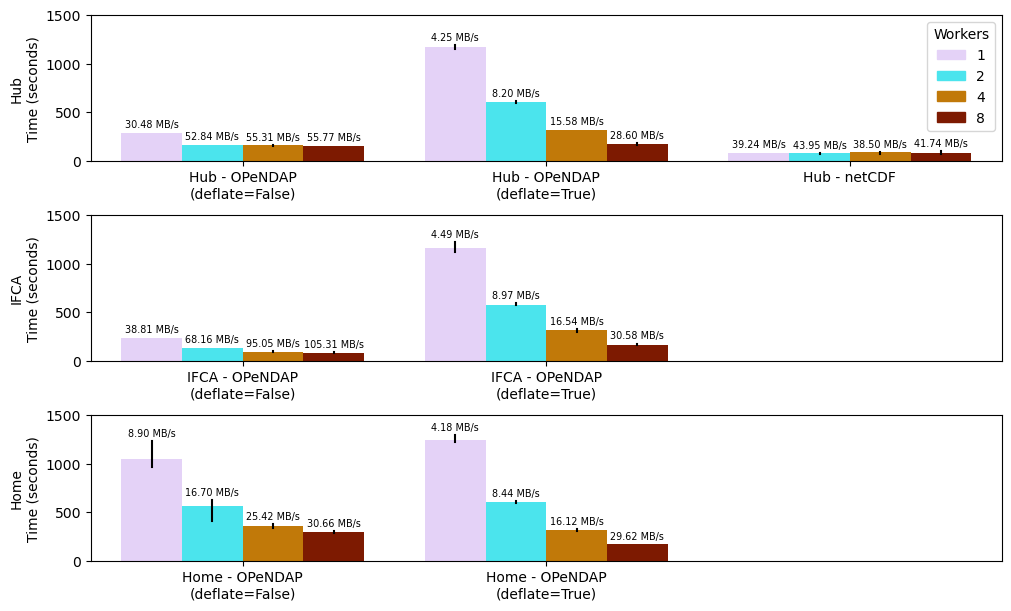

In [4]:
fig, axes = plt.subplots(3, 1, layout='constrained', figsize=(10, 6), sharey=True)

workers = [1, 2, 4, 8]
workers_colors = ["#E4D2F7", "#4BE4ED", "#C17909", "#7D1A01"]
workers_color_dict = dict(zip(workers, workers_colors))

time_means = hub_mean[("time", "mean")].values
time_workers = hub_mean[("time", "mean")].index.get_level_values("workers")

axes[0].bar(
    [0,1,2,3] + [5,6,7,8] + [10,11,12,13],
    time_means,
    color = time_workers.map(workers_color_dict).values,
    width=1)

axes[0].set_xticks(
    [1.5, 6.5, 11.5], [" - ".join([a,b]) for a,b,_ in hub_mean.index[::4].values])
axes[0].set_ylabel("Hub\nTime (seconds)")
axes[0].legend(handles=[plt.Rectangle((0,0),1,1, color=workers_color_dict[label]) for label in workers], labels=workers, title="Workers")

for i,row in enumerate([0,1,2,3,5,6,7,8,10,11,12,13]):
    axes[0].plot([row,row], [hub_mean[("time", "min")].iloc[i], hub_mean[("time", "max")].iloc[i]], c="black")
    axes[0].text(row, hub_mean[("time", "max")].iloc[i] + 50,
                 f"{hub_mean[('throughput', 'mean')].iloc[i]:.2f} MB/s",
                 ha="center", size="x-small")

time_means = home_mean[("time", "mean")].values
time_workers = home_mean[("time", "mean")].index.get_level_values("workers")

axes[2].bar(
    [0,1,2,3] + [5,6,7,8],
    time_means,
    color = time_workers.map(workers_color_dict).values,
    width=1)

axes[2].set_xticks(
    [1.5,6.5], [" - ".join([a,b]) for a,b,_ in home_mean.index[::4].values])
axes[2].set_ylabel("Home\nTime (seconds)")

for i,row in enumerate([0,1,2,3,5,6,7,8]):
    axes[2].plot([row,row], [home_mean[("time", "min")].iloc[i], home_mean[("time", "max")].iloc[i]], c="black")
    if i < 8:
        axes[2].text(row, home_mean[("time", "max")].iloc[i] + 50,
                     f"{home_mean[('throughput', 'mean')].iloc[i]:.2f} MB/s",
                     ha="center", size="x-small")

time_means = ifca_mean[("time", "mean")].values
time_workers = ifca_mean[("time", "mean")].index.get_level_values("workers")

axes[1].bar(
    [0,1,2,3] + [5,6,7,8],
    time_means,
    color = time_workers.map(workers_color_dict).values,
    width=1)

axes[1].set_xticks(
    [1.5,6.5], [" - ".join([a,b]) for a,b,_ in ifca_mean.index[::4].values])
axes[1].set_ylabel("IFCA\nTime (seconds)")

for i,row in enumerate([0,1,2,3,5,6,7,8]):
    axes[1].plot([row,row], [ifca_mean[("time", "min")].iloc[i], ifca_mean[("time", "max")].iloc[i]], c="black")
    if i < 8:
        axes[1].text(row, ifca_mean[("time", "max")].iloc[i] + 50,
                     f"{ifca_mean[('throughput', 'mean')].iloc[i]:.2f} MB/s",
                     ha="center", size="x-small")

axes[0].set_xlim(-1, 14)
axes[1].set_xlim(-1, 14)
axes[2].set_xlim(-1, 14)
axes[0].set_ylim(0, 1500)
axes[1].set_ylim(0, 1500)
axes[2].set_ylim(0, 1500)
    
plt.savefig("performance.svg")